# Fig 2 + Ext Data Fig 2

This notebook produces all analyses in Figure 2 and Extended Data Figure 2.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from helper_funcs import *

# Import data

## TO DO: Set the following local paths the Source Data excel files for Figure 2 and Extended Data Figure 2

In [2]:
SOURCE_DATA_FIG = "/Users/iboyle/Files/TargetDiscovery/PELO/PELO-dev/Source Data/Figure 2.xlsx"
SOURCE_DATA_EXT_FIG = "/Users/iboyle/Files/TargetDiscovery/PELO/PELO-dev/Source Data/Ext Figure 2.xlsx"

# Prep Figure 2 Panels

## Panel A: PELO viability

In [3]:
#cell line 9p21.3 and MSI status
characterization = pd.DataFrame({
    "SW620":[False, False],
    "SW837":[False, False],
    "SF295":["short", False],
    "KP4":["short", False],
    "GB1":[True, False],
    "SU8686":[True, False],
    "MIA PaCa-2":[True, False],
    "IGROV-1":[False, True],
    "KM12":[False, True],
    "HCT116":[False, True],
}, index=["9p21.3-/-", "MSI-H"]).replace({True:"+", False:"-"})
characterization

,SW620,SW837,SF295,KP4,GB1,SU8686,MIA PaCa-2,IGROV-1,KM12,HCT116
9p21.3-/-,-,-,short,short,+,+,+,-,-,-
MSI-H,-,-,-,-,-,-,-,+,+,+


In [4]:
fig2a_data = pd.read_excel(SOURCE_DATA_FIG, sheet_name="Fig2a")

def read_fig2a(cell_line, rows, cols, repeat=False, data=fig2a_data):
    df = pd.DataFrame(
        data.iloc[rows[0]:rows[1], cols[0]+1:cols[1]].values, index=data.iloc[rows[0]:rows[1], cols[0]].rename("gRNA")
    ).stack().to_frame("Relative Viability").reset_index().rename(columns={"level_1":"Rep"})
    if repeat is not False:
        df["Rep"] += repeat
    df["Cell Line"] = cell_line
    return df

fig2a_rows_cols = [
    ("SW620", (0,7), (0,4), False),
    ("SW620", (0,6), (5,9), 3),
    ("SW837", (9,17), (0,4), False),
    ("SW837", (9,16), (5,9), 3),
    ("SF295", (18,26), (0,4), False),
    ("SF295", (18,25), (5,9), 3),
    ("KP4", (27,35), (0,4), False),
    ("KP4", (27,33), (5,10), 3),
    ("GB1", (36,44), (0,4), False),
    ("GB1", (36,42), (5,10), 3),
    ("SU8686", (45,53), (0,4), False),
    ("SU8686", (45,51), (5,9), 3),
    ("MIA PaCa-2", (54,62), (0,4), False),
    ("MIA PaCa-2", (54,60), (5,9), 3),
    ("IGROV-1", (63,70), (5,9), False),
    ("KM12", (71,79), (0,4), False),
    ("KM12", (71,77), (5,9), 3),
    ("HCT116", (80,88), (0,4), False),
    ("HCT116", (80,87), (5,9), 3),
]
fig2a_viab = pd.concat([read_fig2a(*params) for params in fig2a_rows_cols]).reset_index(drop=True)

In [5]:
#get viability in each group
fig2a_viab_w_cat = fig2a_viab.copy()
categories = pd.concat([
    pd.Series("Neutral", characterization.columns[(characterization.isin(["-", "short"])).all()]),
    pd.Series("MSI-H", characterization.columns[characterization.loc["MSI-H"] == "+"]),
    pd.Series("9p21.3-/-", characterization.columns[characterization.loc["9p21.3-/-"] == "+"])
])
fig2a_viab_w_cat["Characterization"] = fig2a_viab_w_cat["Cell Line"].replace(categories)
fig2a_viab_w_cat = fig2a_viab_w_cat.loc[fig2a_viab_w_cat["Characterization"].isin(categories.values)]

#test whether KD of PELO causes lower viability then KD of neg controls in each group
fig2a_stats = ttest_vs_negcons(
    fig2a_viab_w_cat, "gRNA", neg_cons=["Empty Vector", "Ch2-2"], to_test=["PELO#1", "PELO#2", "PELO#8"],
    groupby="Characterization", alternative='less'
).loc[["Neutral", "9p21.3-/-", "MSI-H", ]]

fig2a_ys = pd.Series([2.5, 1.4, 1.1], [1.5, 5, 8])
fig2a_sig = pd.Series(fig2a_stats["p-val"].values, [1.5, 5,8]).apply(lambda x: to_scientific(x, prefix="$p$="))

fig2a_stats

,statistic,p-val,q,Effect Size,n
Characterization,,,,,
Neutral,-0.529173,2.988759e-01,2.988759e-01,-0.030071,112
9p21.3-/-,-11.829431,8.521503e-20,2.556451e-19,-1.200420,85
MSI-H,-12.148641,1.423909e-18,2.135864e-18,-1.095784,66


## Panel B: MIAPACA2 PELO Restoration

In [6]:
fig2b_data = pd.read_excel(SOURCE_DATA_FIG, sheet_name="Fig2b")

fig2b_luc = pd.DataFrame(
    fig2b_data.iloc[2:9, 1:5].values, index=fig2b_data.iloc[2:9, 0].rename("gRNA")
).stack().to_frame("Relative Viability").reset_index().rename(columns={"level_1":"Rep"})
fig2b_luc["cDNA"] = "Luc"
fig2b_pelo = pd.DataFrame(
    fig2b_data.iloc[2:9, 6:10].values, index=fig2b_data.iloc[2:9, 5].rename("gRNA")
).stack().to_frame("Relative Viability").reset_index().rename(columns={"level_1":"Rep"})
fig2b_pelo["cDNA"] = "PELO"
fig2b_viab = pd.concat([fig2b_luc, fig2b_pelo])

In [7]:
#get average of PELO guides' and neg ctrl guides' viability per replicate/cDNA
pelo_guides_reps = fig2b_viab.loc[
    fig2b_viab["gRNA"].isin(["PELO#1", "PELO#2", "PELO#8"])
].groupby(["Rep", "cDNA"])["Relative Viability"].mean()
neg_ctrl_guide_reps = fig2b_viab.loc[
    fig2b_viab["gRNA"].isin(["Ch2-2", "Empty Vector"])
].groupby(["Rep", "cDNA"])["Relative Viability"].mean()
#find difference between mean PELO and neg ctrl guides per replicate/cDNA
diffs = pelo_guides_reps.subtract(neg_ctrl_guide_reps).reset_index()

#test whether difference in viability between PELO and neg ctrl guides is greater in PELO cDNA then Luc cDNA
fig2b_stats = ttest_vs_negcons(
    diffs, var_col="cDNA", neg_cons=["Luc"], to_test=["PELO"], alternative="greater"
).to_frame("PELO").T
sig_B_label = to_scientific(fig2b_stats.loc["PELO", "p-val"])
fig2b_stats

,statistic,p-val,Effect Size,n
PELO,34.540446,0.000002,0.675055,6.0


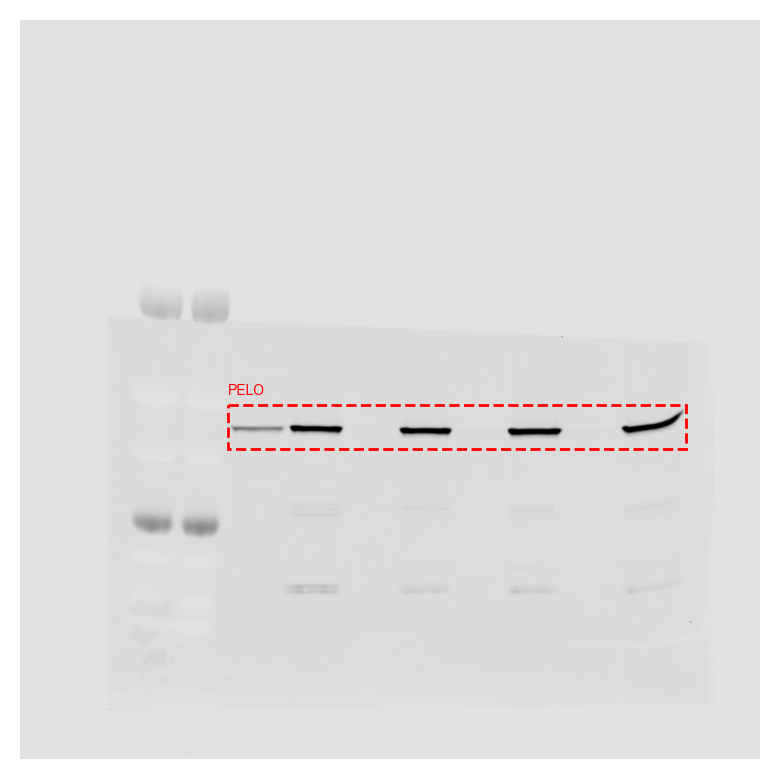

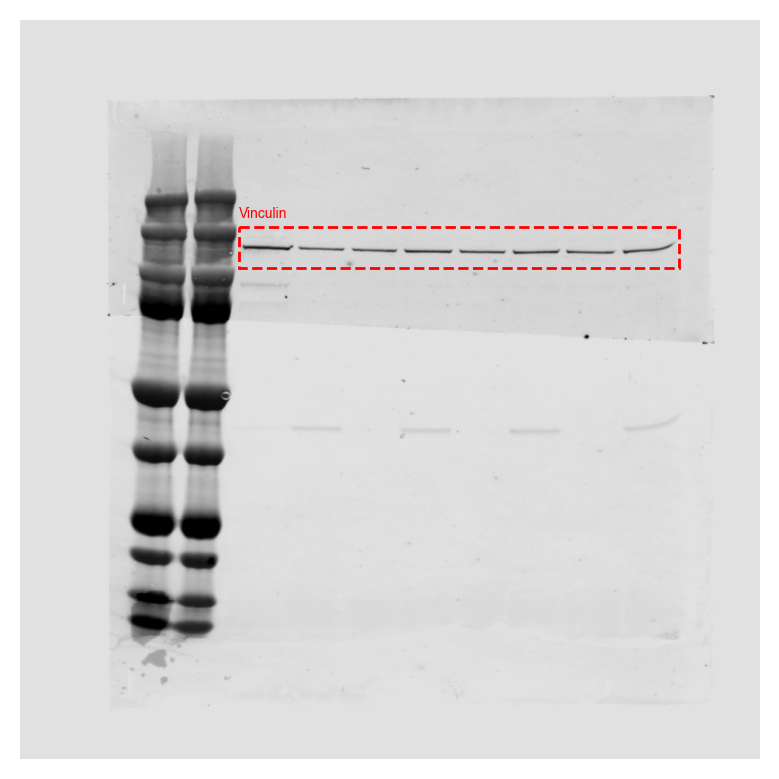

In [8]:
fig2b_PELO_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 2/Fig2b_PELO.tif', {"PELO":[520,580, 280,900]})
fig2b_Vinc_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 2/Fig2b_Vinculin.tif', {"Vinculin":[280,335, 295,890]})

## Panel C: Organoid PELO Viability

In [9]:
fig2c_data = pd.read_excel(SOURCE_DATA_FIG, sheet_name="Fig2c")

fig2c_pf0071 = pd.DataFrame(
    fig2c_data.iloc[3:5, 0:3].values, columns=fig2c_data.iloc[2, 0:3].rename("KO")
).T.stack().to_frame("mean").reset_index().replace({"PELO2":"PELO#2"})
fig2c_panfr0127 = pd.DataFrame(
    fig2c_data.iloc[3:5, 4:7].values, columns=fig2c_data.iloc[2, 4:7].rename("KO")
).T.stack().to_frame("mean").reset_index().replace({"PELO2":"PELO#2"})
fig2c_cclfcore001 = pd.DataFrame(
    fig2c_data.iloc[3:6, 8:11].values, columns=fig2c_data.iloc[2, 8:11].rename("KO")
).T.stack().to_frame("mean").reset_index().replace({"PELO2":"PELO#2"})

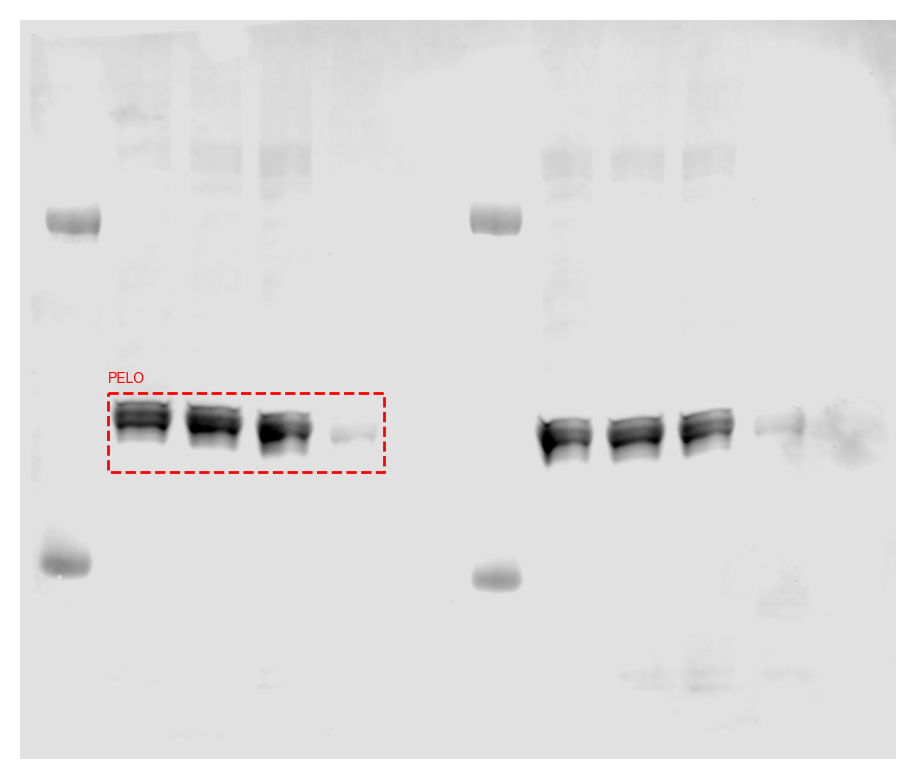

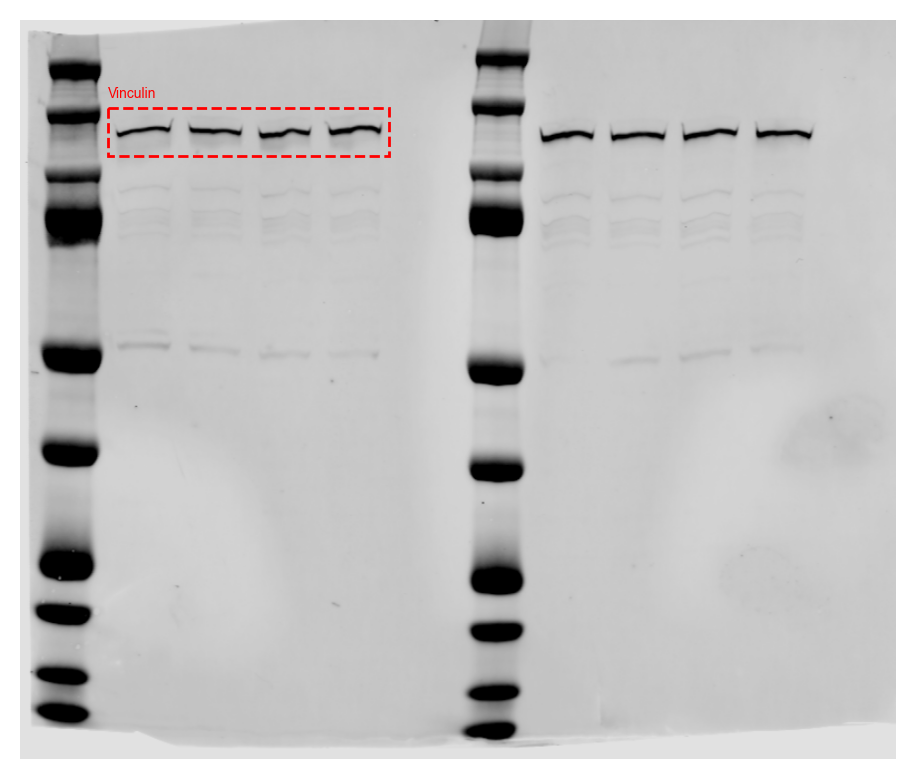

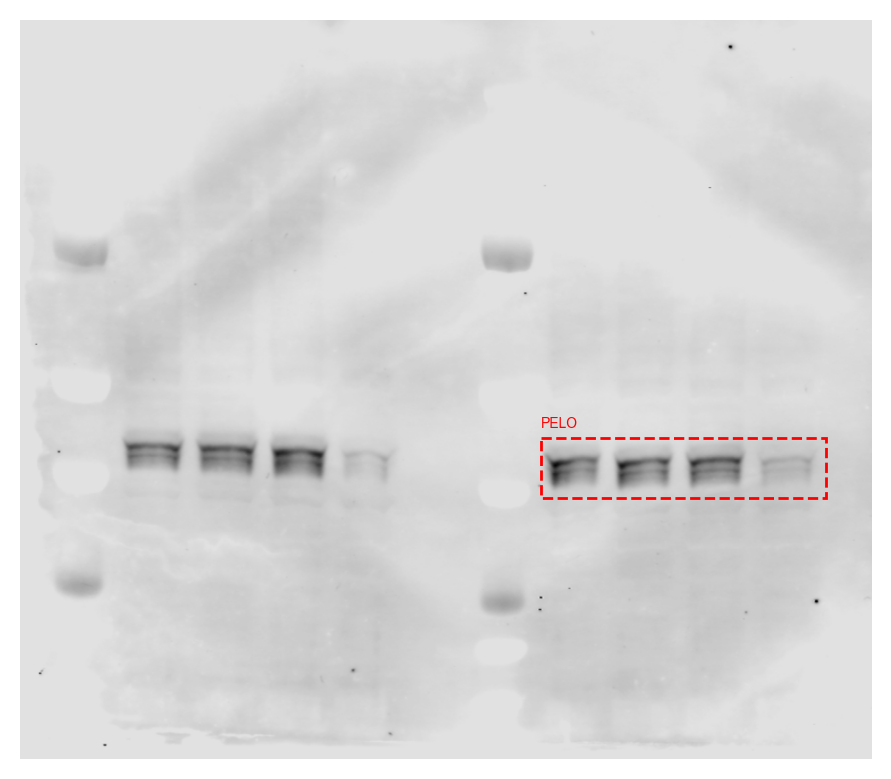

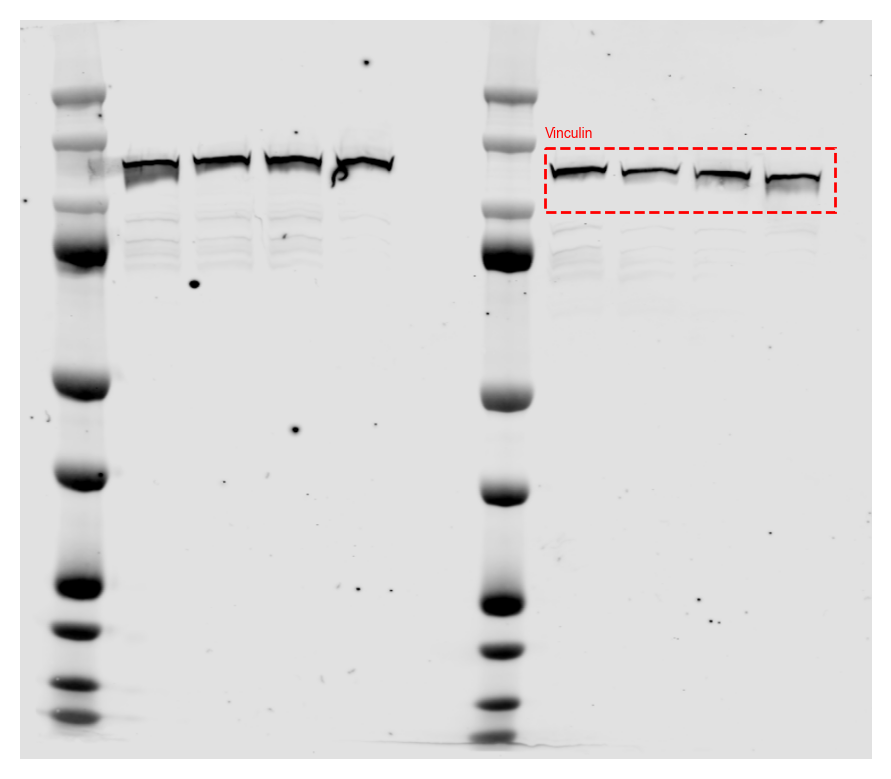

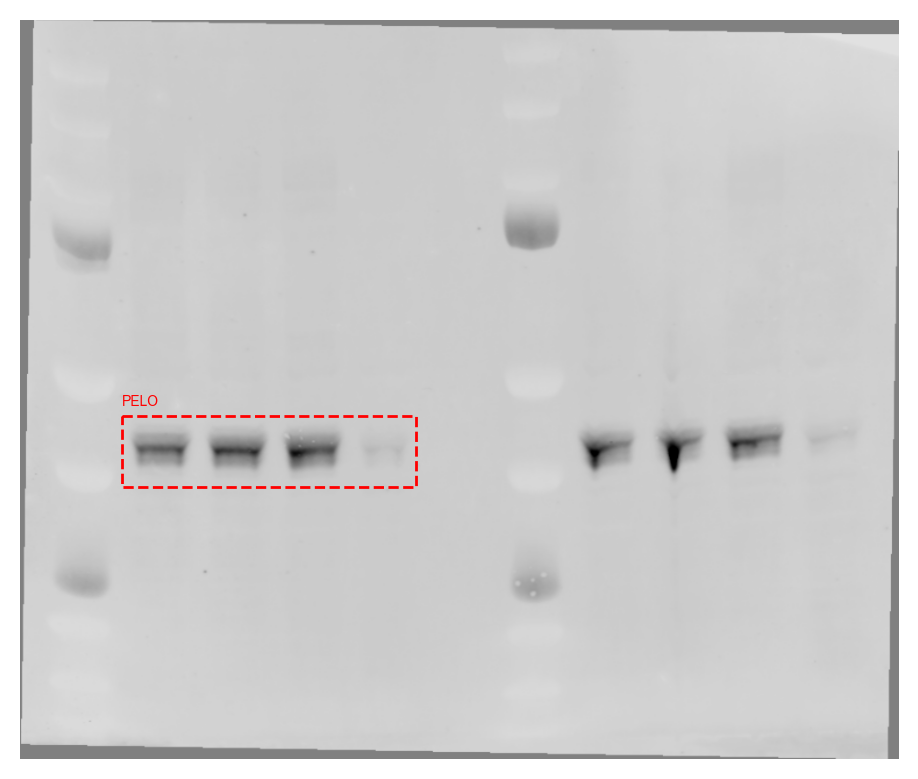

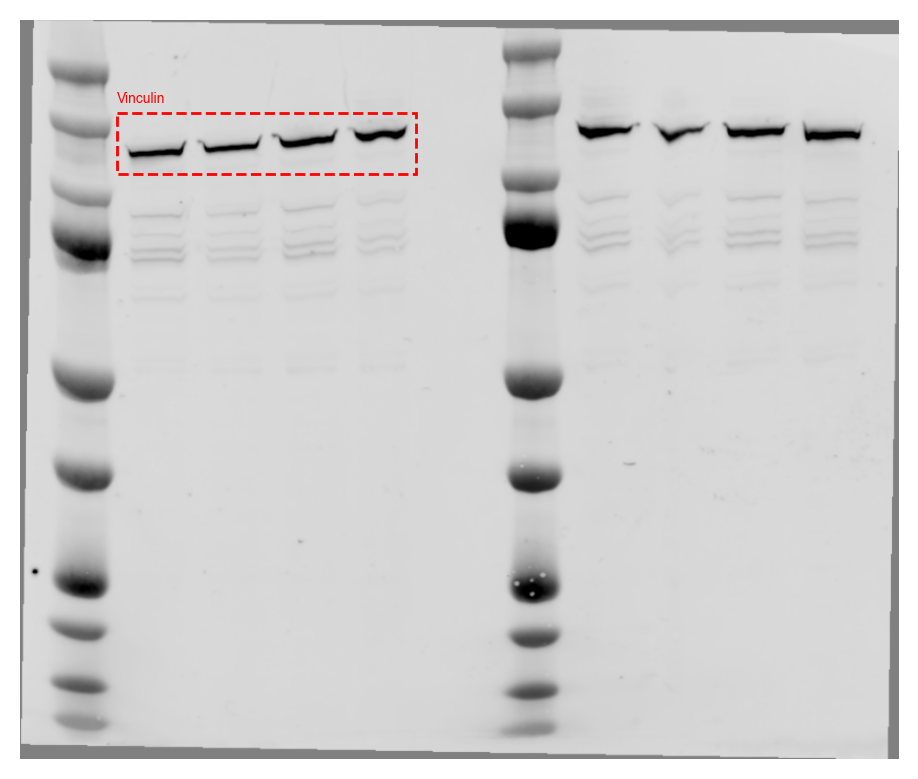

In [10]:
fig2c_PANFR0127_PELO_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 2/Fig2c_PANFR127_PELO.tif', {"PELO":[425,515, 100,415]})
fig2c_PANFR0127_Vinc_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 2/Fig2c_PANFR127_Vinculin.tif', {"Vinculin":[100,155, 100,420]})
fig2c_PANFR0071_PELO_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 2/Fig2c_PANFR0071_PELO.tif', {"PELO":[490,560, 610,945]})
fig2c_PANFR0071_Vinc_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 2/Fig2c_PANFR0071_Vinculin.tif', {"Vinculin":[150,225, 615,955]})
fig2c_CCLF_CORE_0001_PELO_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 2/Fig2c_CCLF_CORE_0001_PELO.tif', {"PELO":[450,530, 115,450]})
fig2c_CCLF_CORE_0001_Vinc_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 2/Fig2c_CCLF_CORE_0001_Vinculin.tif', {"Vinculin":[105,175, 110,450]})

## Panel D: In Vivo Data

In [11]:
fig2d_data = pd.read_excel(SOURCE_DATA_FIG, sheet_name="Fig2d")

fig2d_data_dox_neg = pd.DataFrame(
    fig2d_data.iloc[2:16, 1:24].values, 
    columns=fig2d_data.iloc[1, 1:24].astype(float).rename("Day"), 
    index=fig2d_data.iloc[2:16, 0].rename("Tumor")
).astype(float).dropna(how="all")
fig2d_data_dox_pos = pd.DataFrame(
    fig2d_data.iloc[20:29, 1:31].values, 
    columns=fig2d_data.iloc[19, 1:31].astype(float).rename("Day"), 
    index=fig2d_data.iloc[20:29, 0].rename("Tumor")
).astype(float)

## Panel E: Kaplan-Meier

In [12]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

fig2e_obs = pd.read_excel(SOURCE_DATA_FIG, sheet_name="Fig2e")

def plot_km(ax, colors={"PELO KD (DOX+)":PELO_GUIDES[1], "control (DOX-)":NEG_CON}):
    kmf = KaplanMeierFitter()
    for cohort in fig2e_obs['cohort'].unique():
        ix = fig2e_obs['cohort'] == cohort
        kmf.fit(fig2e_obs.loc[ix, 'end'], fig2e_obs.loc[ix, 'status'], label=cohort)
        kmf.plot(ax=ax, ci_show=False, color=colors[cohort])
    ax.set_xlabel('Time on treatment (days)')
    ax.set_ylabel('Fraction Surviving')

km_pval = pairwise_logrank_test(fig2e_obs['end'], fig2e_obs['cohort'], fig2e_obs['status']).summary
km_pval_label = to_scientific(km_pval.loc[("PELO KD (DOX+)", "control (DOX-)"), "p"], prefix="$p$=")
print(fig2e_obs.shape)
km_pval

(11, 4)


,,test_statistic,p,-log2(p)
PELO KD (DOX+),control (DOX-),9.714253,0.001828,9.095168


# Construct Figure 2

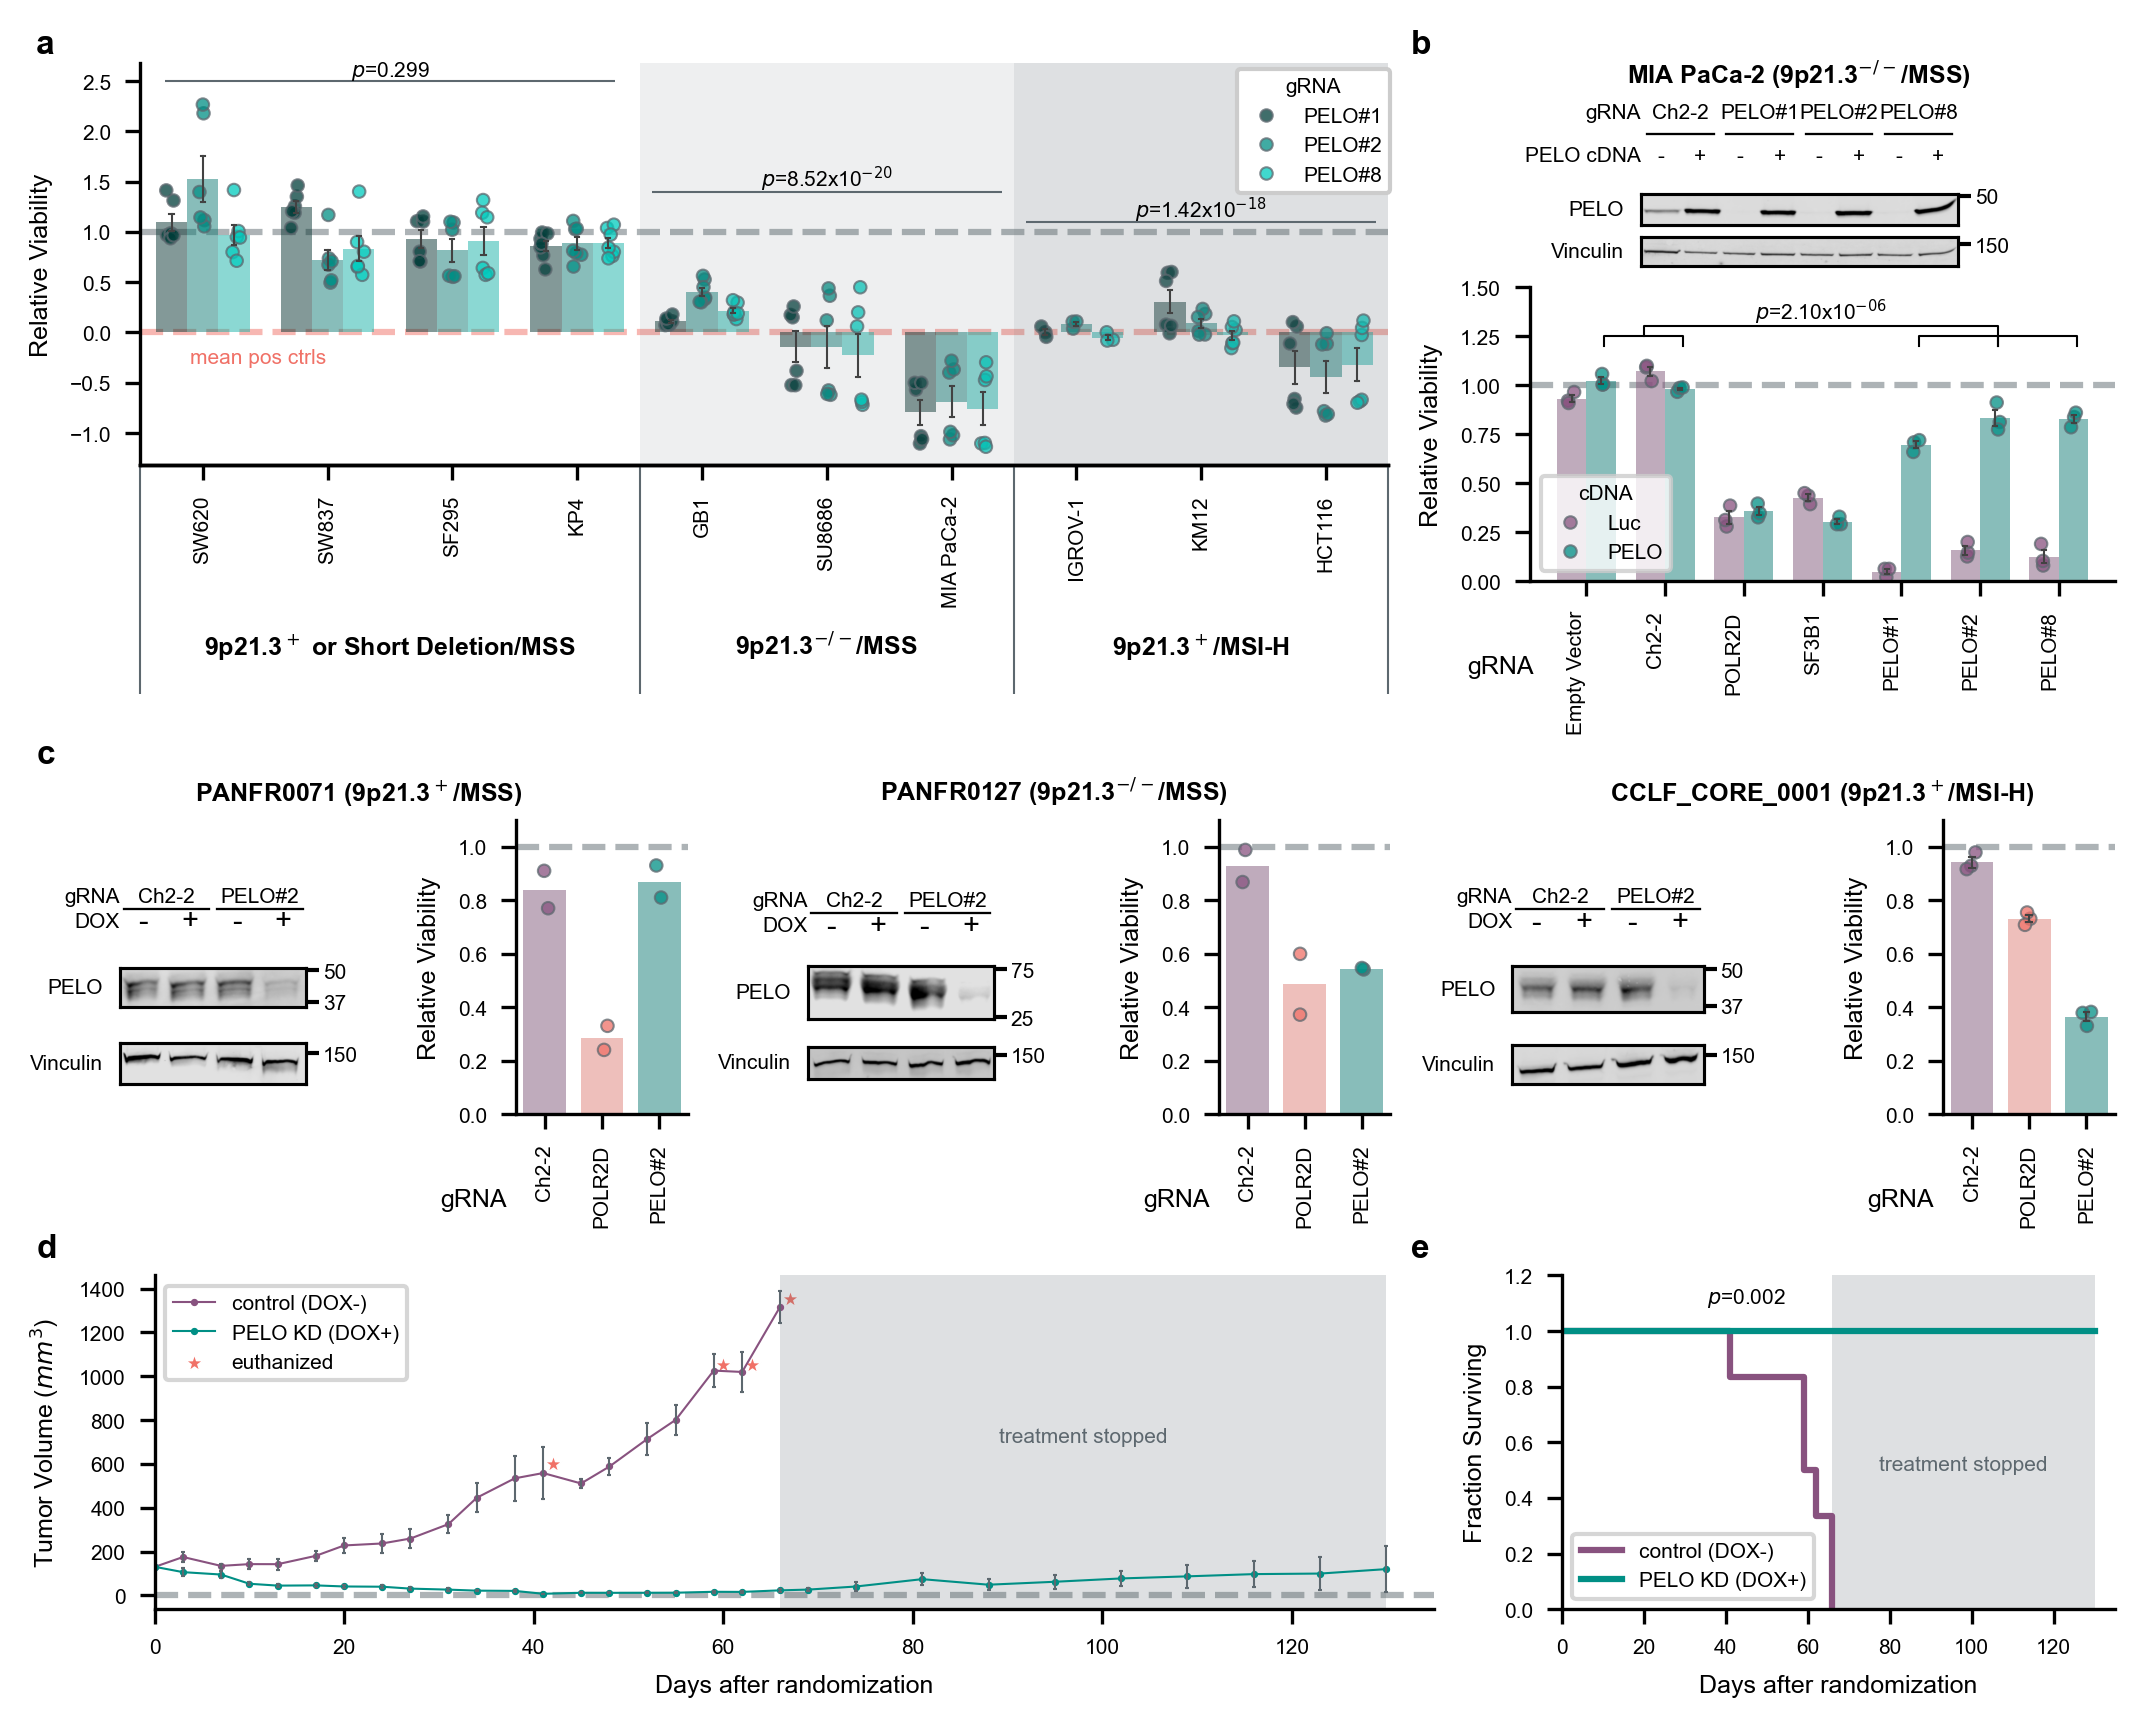

In [13]:
fig2 = plt.figure(layout="constrained", dpi=300, figsize=(DOUBLE_IN, 5.5))

gs = fig2.add_gridspec(nrows=7, ncols=6, height_ratios=[0.75, 1, 0.1, 0.01, 1, 0.1, 1.5], 
                       width_ratios=[1, 0.5, 1, 0.5, 0.7, 0.5])

As = gs[0:2, 0:4].subgridspec(nrows=2, ncols=1, height_ratios=[1, 0.1], hspace=0)
A = fig2.add_subplot(As[0])
fancybar(
    data=fig2a_viab, 
    x="Cell Line", y="Relative Viability", hue="gRNA",
    order=characterization.columns.tolist(),
    hue_order=["PELO#1", "PELO#2", "PELO#8"], palette=PELO_GUIDES,
    s=3, ax=A
)
A.set_xticks(A.get_xticks())
A.set_xticklabels(labels=A.get_xticklabels(), rotation=90)
A.set_xlabel(None)
axline(A, "h", 1)
axline(A, "h", 0, color=POS_CON)
A.text(-0.1, -0.3, "mean pos ctrls", color=POS_CON)
A.legend(title="gRNA", loc="upper right", framealpha=1, bbox_to_anchor=(1.01,1.01))
add_labels_to_ax(A, fig2a_ys.iloc[1:], fig2a_sig.iloc[1:], y_adj=0.05, line_adj=(1.4, 0.0))
add_labels_to_ax(A, fig2a_ys.iloc[[0]], fig2a_sig.iloc[[0]], y_adj=0.05, line_adj=(1.8, 0.0))
#secondary axis and highlights
A2 = A.secondary_xaxis(location=0)
A2.set_xticks(
    [1.5, 5, 8], labels=[r'9p21.3$^+$ or Short Deletion/MSS', r'9p21.3$^{-/-}$/MSS', r'9p21.3$^+$/MSI-H'], 
    weight="bold", va="center", size=6
)
A2.tick_params('x', length=40, bottom=False)
splits = [-0.5, 3.5, 6.5, 9.5]
for i in range(0, len(splits)-1):
    A.axvspan(splits[i], splits[i+1], alpha=(i*0.1), color=ACCENT, linewidth=0)
A2s = A.secondary_xaxis(location=0)
A2s.set_xticks(splits, ['', '', '', ''])
A2s.tick_params('x', length=55, colors=ACCENT, width=0.5)
A.set_xlim(splits[0], splits[-1])

B_ratios = get_wb_height_ratios([fig2b_PELO_cropped["PELO"], fig2b_Vinc_cropped["Vinculin"]])
Bs = gs[0, 4:].subgridspec(nrows=5, ncols=2, width_ratios=[0.1, 1], height_ratios=[0.05]+B_ratios+[0.05], hspace=0)
Bb = fig2.add_subplot(Bs[0, 1])
Bb.annotate(
    r"MIA PaCa-2 (9p21.3$^{-/-}$/MSS)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
Bb.set_axis_off()
BL = fig2.add_subplot(Bs[1, 1])
add_wb_labels(
    BL, [
        ("gRNA", ["Ch2-2", "PELO#1", "PELO#2", "PELO#8"]), 
        ("_", ["_","_","_","_",]),
        ("PELO cDNA", ["-", "+","-", "+","-", "+","-", "+",])
    ]
)
B1 = fig2.add_subplot(Bs[2, 1])
wb_image(B1, "PELO", fig2b_PELO_cropped["PELO"], ladder={"50":0.95})
B2 = fig2.add_subplot(Bs[3, 1])
wb_image(B2, "Vinculin", fig2b_Vinc_cropped["Vinculin"], ladder={"150":0.75})
B3 = fig2.add_subplot(gs[1, 4:])
fancybar(
    data=fig2b_viab, 
    x="gRNA", y="Relative Viability", hue="cDNA", 
    order=["Empty Vector", "Ch2-2", "POLR2D", "SF3B1", "PELO#1", "PELO#2", "PELO#8"], 
    hue_order=["Luc", "PELO"], palette=[NEG_CON, PELO_GUIDES[1]],
    s=3, ax=B3
)
add_bracket(B3, sig_B_label, [["Empty Vector", "Ch2-2"], ["PELO#1", "PELO#2", "PELO#8",]], 1.3)
B3.set_ylim(0, 1.5)
B3.set_ylabel("Relative Viability")
B3.set_xlabel("gRNA")
B3.xaxis.set_label_coords(-0.05, -0.25)
B3.set_xticks(B3.get_xticks())
B3.set_xticklabels(labels=B3.get_xticklabels(), rotation=90, ha="right")
axline(B3, "h", 1)
B3.legend(title="cDNA", loc="lower left")

Ca = fig2.add_subplot(gs[3,0:2])
Ca.annotate(
    r"PANFR0071 (9p21.3$^+$/MSS)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
Ca.set_axis_off()
C_ratios = get_wb_height_ratios([fig2c_PANFR0071_PELO_cropped["PELO"], fig2c_PANFR0071_Vinc_cropped["Vinculin"]])
Cs = gs[4, 0].subgridspec(nrows=5, ncols=1, height_ratios=[1]+C_ratios+[2], hspace=0)
CLa = fig2.add_subplot(Cs[1])
add_wb_labels(
    CLa, [("gRNA",["Ch2-2", "PELO#2"]), ("_", ["_","_"]), ("DOX", ["-","+","-","+"])]
)
C1a = fig2.add_subplot(Cs[2])
wb_image(C1a, "PELO", fig2c_PANFR0071_PELO_cropped["PELO"], ladder={"50":0.95, "37":0.15})
C2a = fig2.add_subplot(Cs[3])
wb_image(C2a, "Vinculin", fig2c_PANFR0071_Vinc_cropped["Vinculin"], ladder={"150":0.75})
C3a = fig2.add_subplot(gs[4, 1])
fancybar(
    data=fig2c_pf0071,
    x="KO", y="mean", s=3, ax=C3a,
    order=["Ch2-2", "POLR2D", "PELO#2"], dodge=False, errorbar=None,
    hue="KO", palette=[NEG_CON, POS_CON, PELO_GUIDES[1]]
)
C3a.set_xticks(C3a.get_xticks())
C3a.set_xticklabels(labels=C3a.get_xticklabels(), rotation=90, ha="center")
axline(C3a, "h", 1)
C3a.set_xlabel("gRNA")
C3a.xaxis.set_label_coords(-0.25, -0.25)
C3a.set_ylabel("Relative Viability")
C3a.set_ylim(0, 1.1)


Cb = fig2.add_subplot(gs[3,2:4])
Cb.annotate(
    r"PANFR0127 (9p21.3$^{-/-}$/MSS)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
Cb.set_axis_off()
Cs2_ratios = get_wb_height_ratios([fig2c_PANFR0127_PELO_cropped["PELO"], fig2c_PANFR0127_Vinc_cropped["Vinculin"]])
Cs2 = gs[4, 2].subgridspec(nrows=5, ncols=1, height_ratios=[1]+Cs2_ratios+[2], hspace=0)
CLb = fig2.add_subplot(Cs2[1])
add_wb_labels(
    CLb, [("gRNA",["Ch2-2", "PELO#2"]), ("_", ["_","_"]), ("DOX", ["-","+","-","+"])]
)
C1b = fig2.add_subplot(Cs2[2])
wb_image(C1b, "PELO", fig2c_PANFR0127_PELO_cropped["PELO"], ladder={"75":0.95, "25":0.05})
C2b = fig2.add_subplot(Cs2[3])
wb_image(C2b, "Vinculin", fig2c_PANFR0127_Vinc_cropped["Vinculin"], ladder={"150":0.75})
C3b = fig2.add_subplot(gs[4,3])
fancybar(
    data=fig2c_panfr0127,
    x="KO", y="mean", s=3, ax=C3b,
    order=["Ch2-2", "POLR2D", "PELO#2"], dodge=False, errorbar=None,
    hue="KO", palette=[NEG_CON, POS_CON, PELO_GUIDES[1]]
)
C3b.set_xticks(C3b.get_xticks())
C3b.set_xticklabels(labels=C3b.get_xticklabels(), rotation=90, ha="center")
axline(C3b, "h", 1)
C3b.set_xlabel("gRNA")
C3b.xaxis.set_label_coords(-0.25, -0.25)
C3b.set_ylabel("Relative Viability")
C3b.set_ylim(0, 1.1)

Cc = fig2.add_subplot(gs[3,4:])
Cc.annotate(
    r"CCLF_CORE_0001 (9p21.3$^+$/MSI-H)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
Cc.set_axis_off()
Cs3_ratios = get_wb_height_ratios([fig2c_CCLF_CORE_0001_PELO_cropped["PELO"], fig2c_CCLF_CORE_0001_Vinc_cropped["Vinculin"]])
Cs3 = gs[4, 4].subgridspec(nrows=5, ncols=2, height_ratios=[1]+Cs3_ratios+[2], width_ratios=[0.01, 1], hspace=0, wspace=0)
CLc = fig2.add_subplot(Cs3[1,1])
add_wb_labels(
    CLc, [("gRNA",["Ch2-2", "PELO#2"]), ("_", ["_","_"]), ("DOX", ["-","+","-","+"])]
)
C1c = fig2.add_subplot(Cs3[2,1])
wb_image(C1c, "PELO", fig2c_CCLF_CORE_0001_PELO_cropped["PELO"], ladder={"50":0.95, "37":0.15})
C2c = fig2.add_subplot(Cs3[3,1])
wb_image(C2c, "Vinculin", fig2c_CCLF_CORE_0001_Vinc_cropped["Vinculin"], ladder={"150":0.75})
C3c = fig2.add_subplot(gs[4,5])
fancybar(
    data=fig2c_cclfcore001,
    x="KO", y="mean", s=3, ax=C3c,
    order=["Ch2-2", "POLR2D", "PELO#2"], dodge=False, 
    hue="KO", palette=[NEG_CON, POS_CON, PELO_GUIDES[1]]
)
C3c.set_xticks(C3c.get_xticks())
C3c.set_xticklabels(labels=C3c.get_xticklabels(), rotation=90, ha="center")
axline(C3c, "h", 1)
C3c.set_xlabel("gRNA")
C3c.xaxis.set_label_coords(-0.25, -0.25)
C3c.set_ylabel("Relative Viability")
C3c.set_ylim(0, 1.1)

DEs = gs[6, :].subgridspec(nrows=1, ncols=3, width_ratios=[1,1,1], hspace=0)
D = fig2.add_subplot(DEs[0, 0:2])
sns.lineplot(
    data=fig2d_data_dox_neg.stack().reset_index(),
    x="Day", y=0, label="control (DOX-)", errorbar="se", err_style="bars",
    color=NEG_CON, marker='o', markeredgecolor=NEG_CON, markersize=1, linewidth=0.5, 
    err_kws=dict(elinewidth=0.5, capsize=0.5, capthick=0.5, ecolor=ACCENT), ax=D
)
sns.lineplot(
    data=fig2d_data_dox_pos.stack().reset_index(),
    x="Day", y=0, label="PELO KD (DOX+)", errorbar="se", err_style="bars",
    color=PELO_GUIDES[1], marker='o', markeredgecolor=PELO_GUIDES[1], markersize=1, linewidth=0.5, 
    err_kws=dict(elinewidth=0.5, capsize=0.5, capthick=0.5, ecolor=ACCENT), ax=D
)
sns.scatterplot(
    x=[42,60,63,67], y=[600,1050,1050,1350], s=20,
    color=POS_CON, marker="*", label="euthanized", ax=D
)
D.axvspan(66, 130, alpha=0.2, color=ACCENT, linewidth=0)
D.text(98, 700, "treatment stopped", color=ACCENT, ha="center")
D.legend(loc="upper left")
axline(D, "h", 0)
D.set_xlim(0, 135)
D.set_xlabel("Days after randomization")
D.set_ylabel(r"Tumor Volume ($mm^3$)")

E = fig2.add_subplot(DEs[0, 2])
plot_km(E)
E.set_xlabel("Days after randomization")
E.axvspan(66, 130, alpha=0.2, color=ACCENT, linewidth=0)
E.set_xlim(0, 135)
E.set_ylim(0, 1.2)
E.text(98, 0.5, "treatment stopped", color=ACCENT, ha="center")
E.text(45, 1.1, km_pval_label, ha="center")

fig2.text(0.01, 1, "a", weight='bold', fontsize=8)
fig2.text(0.66, 1, "b", weight='bold', fontsize=8)
fig2.text(0.01, 0.57, "c", weight='bold', fontsize=8)
fig2.text(0.01, 0.27, "d", weight='bold', fontsize=8)
fig2.text(0.66, 0.27, "e", weight='bold', fontsize=8)

fig2.set_constrained_layout_pads(
    w_pad = 0.05, h_pad = 0.02
)

plt.savefig("figures/Fig2.pdf", transparent=True, bbox_inches='tight',)
plt.savefig("figures/Fig2.jpg", transparent=True, bbox_inches='tight',)

# Prep Extended Data 2 Panels

## Extended Data Panel A: PELO viabilty alternate normalization

In [14]:
extfig2a = pd.read_excel(SOURCE_DATA_EXT_FIG, sheet_name="ExtFig2a")
extfig2a_viab = pd.concat([read_fig2a(*params, data=extfig2a) for params in fig2a_rows_cols]).reset_index(drop=True)

In [15]:
#same as Fig 2a
extfig2a_viab_mod = extfig2a_viab.copy()
extfig2a_viab_mod["Characterization"] = extfig2a_viab_mod["Cell Line"].replace(categories)
extfig2a_viab_mod = extfig2a_viab_mod.loc[extfig2a_viab_mod["Characterization"].isin(categories.values)]

extfig2a_stats = ttest_vs_negcons(
    extfig2a_viab_mod, "gRNA", ["Empty Vector", "Ch2-2"], ["PELO#1", "PELO#2", "PELO#8"],
    groupby="Characterization", vals="Relative Viability", alternative='less'
).loc[["Neutral", "9p21.3-/-", "MSI-H", ]]

extfig2a_ys = pd.Series([1.9, 0.8, 0.75], [1.5, 5, 8])
extfig2a_sig = pd.Series(
    extfig2a_stats["p-val"].apply(lambda x: to_scientific(x, prefix="$p$=")).values, 
    [1.5, 5, 8]
)

extfig2a_stats

,statistic,p-val,q,Effect Size,n
Characterization,,,,,
Neutral,-0.493509,3.113185e-01,3.113185e-01,-0.020751,112
9p21.3-/-,-18.745304,7.157909e-32,2.147373e-31,-0.752281,85
MSI-H,-18.085137,3.794810e-27,5.692215e-27,-0.736979,66


## Extended Data Panel B: PELO WB

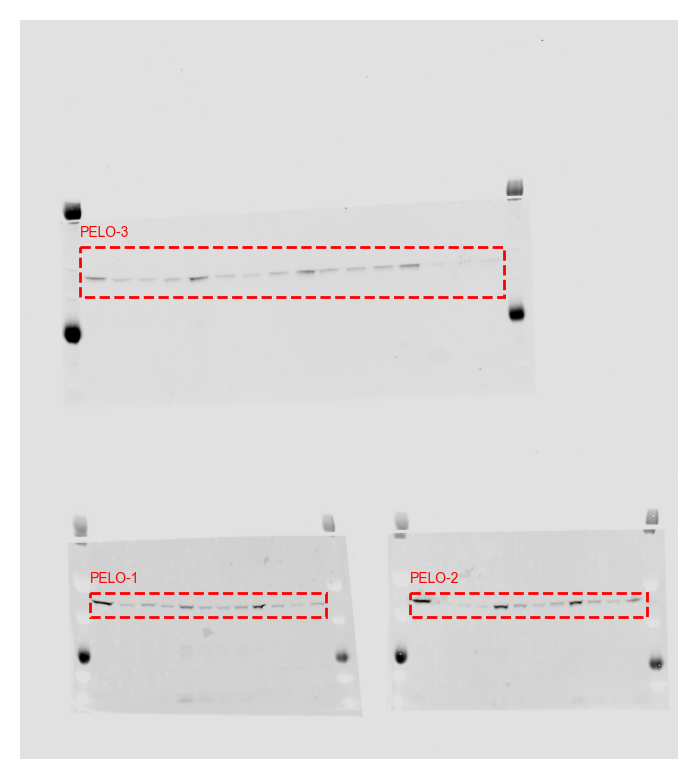

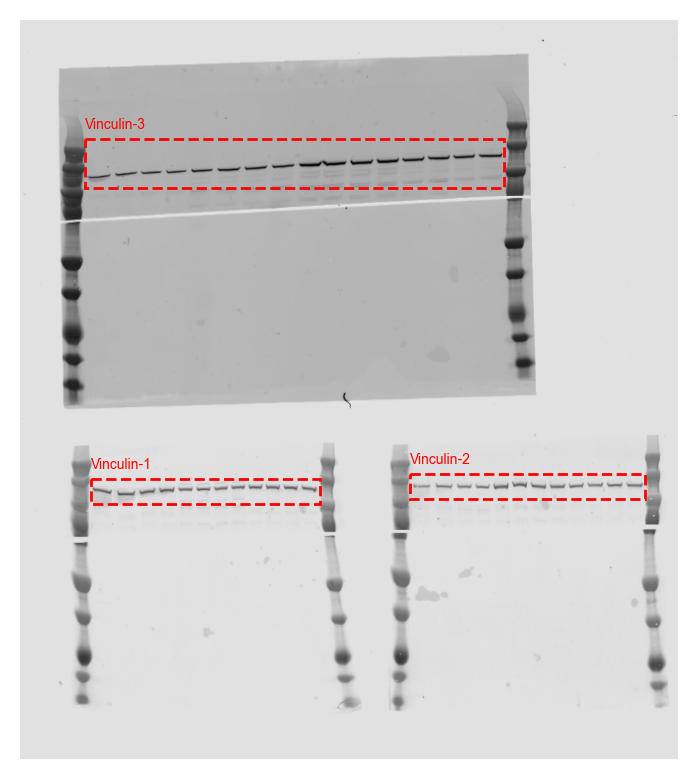

In [16]:
extfig2b_PELO_cropped = crop_and_box_wb(
    IMG_FOLDER+'Extended Figure 2/ExtFig2b_2023_PELO.tif', 
    {"PELO-1":[580,605, 70,310], "PELO-2":[580,605, 395,635], "PELO-3":[230,280, 60,490]}
)
extfig2b_Vinc_cropped = crop_and_box_wb(
    IMG_FOLDER+'Extended Figure 2/ExtFig2b_2023_Vinculin.tif', 
    {"Vinculin-1":[465,490, 71,303], "Vinculin-2":[460,485, 395,633], "Vinculin-3":[120,170, 65,490]}
)

## Extended Data Panel C: In Vivo PELO WB

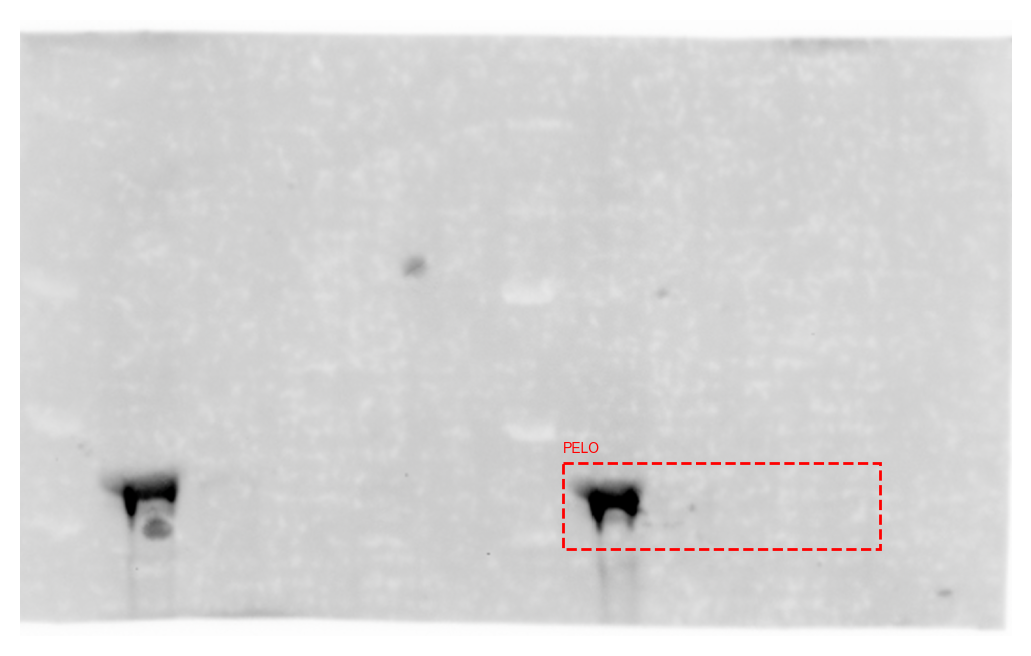

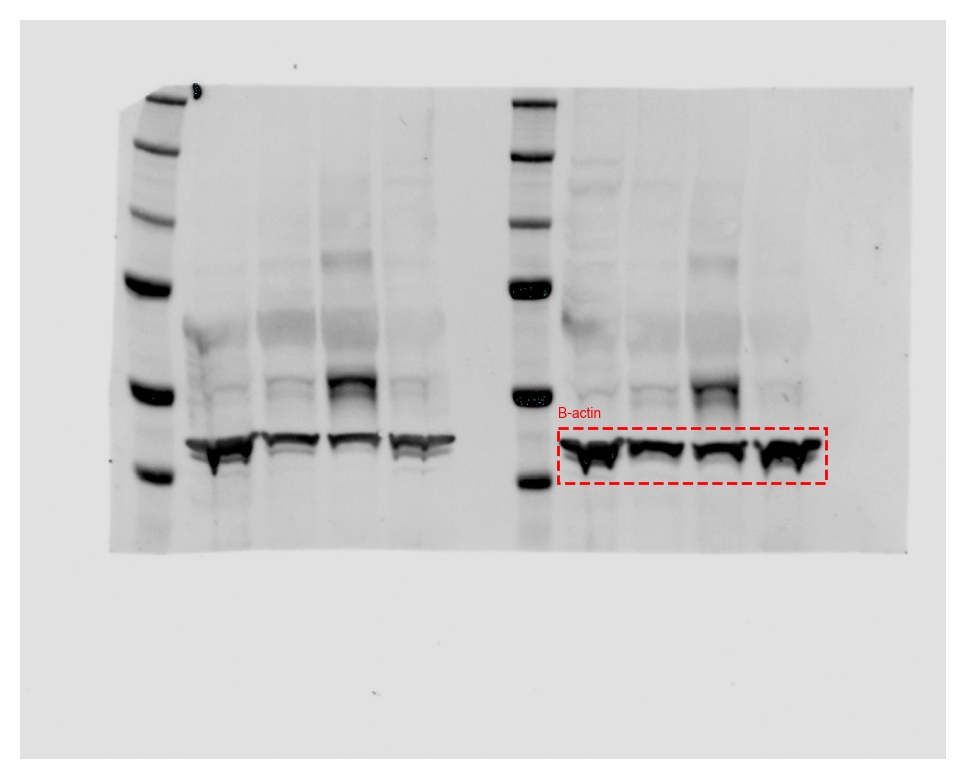

In [17]:
extfig2c_PELO_cropped = crop_and_box_wb(IMG_FOLDER+'Extended Figure 2/ExtFig2c_PELO.png', {"PELO":[670,800, 820,1300]})
extfig2c_b_actin_cropped = crop_and_box_wb(IMG_FOLDER+'Extended Figure 2/ExtFig2c_B_actin.jpg', {"B-actin":[440,500, 580,870]})

# Construct Extended Data Figure 2

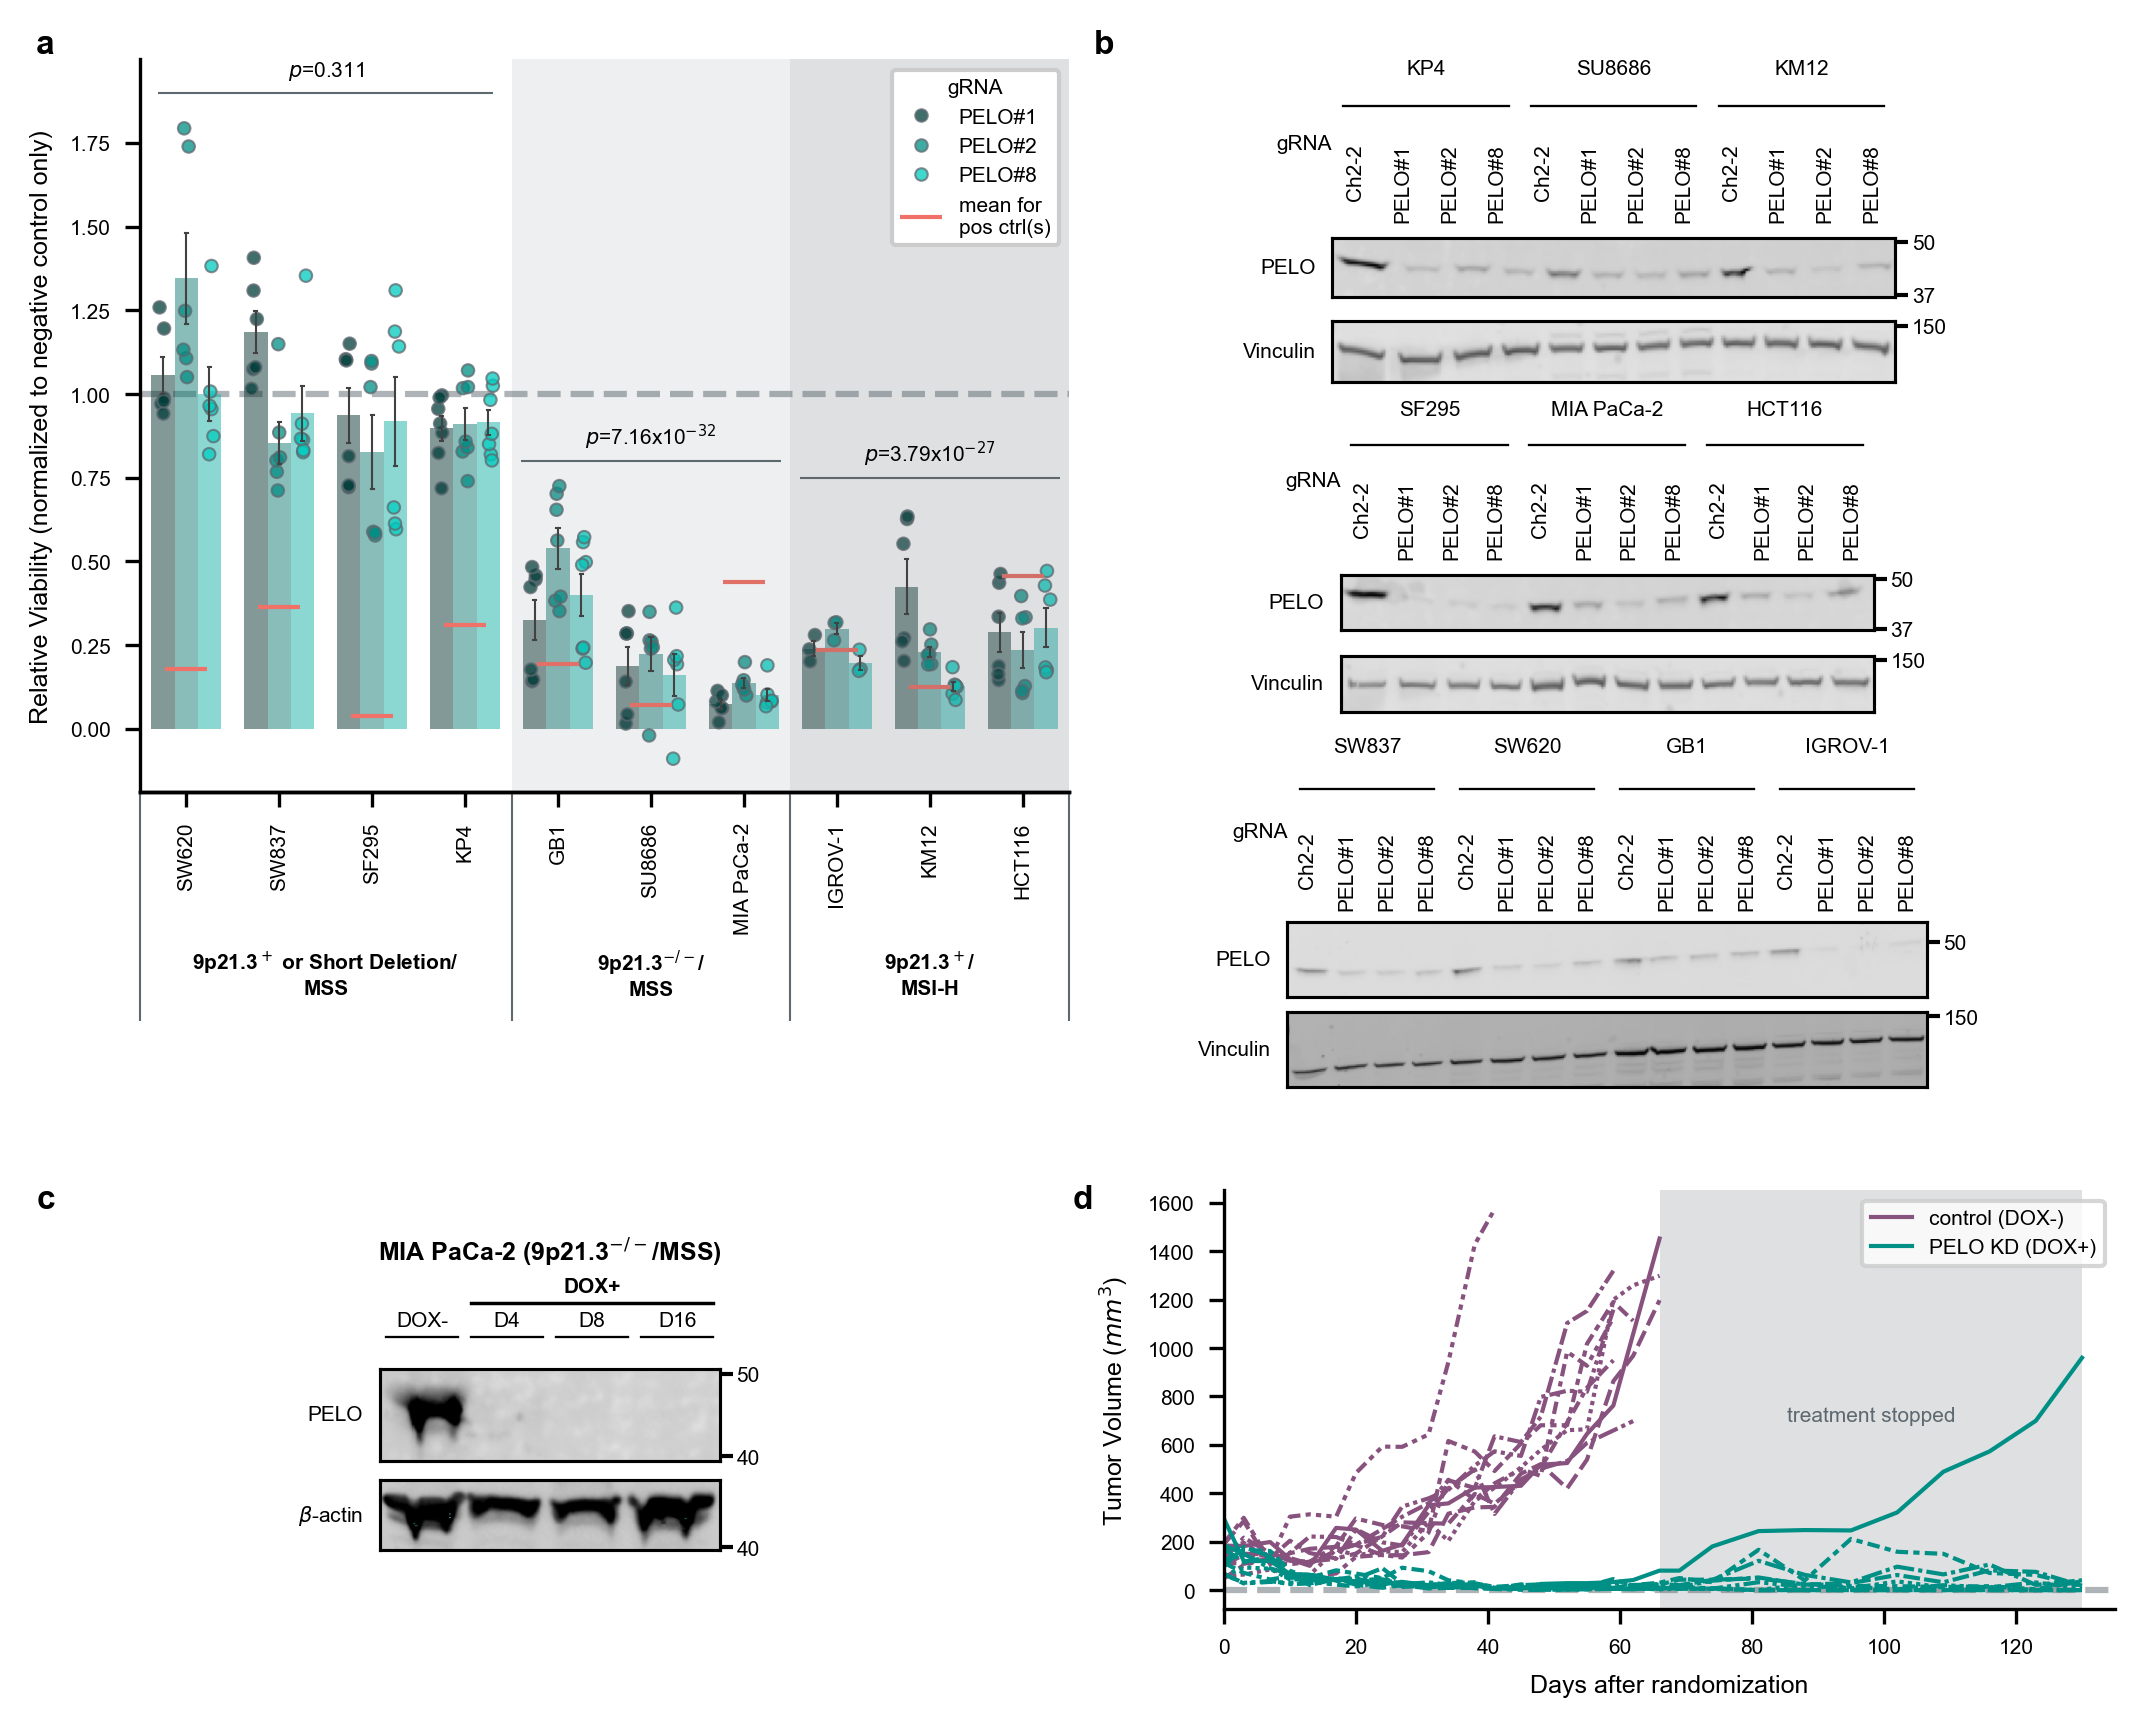

In [18]:
extfig2 = plt.figure(layout="constrained", dpi=300, figsize=(DOUBLE_IN,5.5))

gs = extfig2.add_gridspec(nrows=5, ncols=2, height_ratios=[0.8,0.8,0.9,0.2,1], width_ratios=[1.2,1])

As = gs[0:3, 0].subgridspec(nrows=2, ncols=1, height_ratios=[1, 0.1], hspace=0)
A = extfig2.add_subplot(As[0])
fancybar(
    data=extfig2a_viab, 
    x="Cell Line", y="Relative Viability", hue="gRNA", dodge=True,
    order=characterization.columns.tolist(), s=3,
    palette=PELO_GUIDES, hue_order=["PELO#1", "PELO#2", "PELO#8"], ax=A
)
sns.pointplot(
    data=extfig2a_viab.loc[extfig2a_viab["gRNA"].isin(["POLR2D", "SF3B1"])], 
    x="Cell Line", y="Relative Viability", 
    marker="_", markersize=10, markeredgewidth=1, 
    dodge=False, errorbar=None, linestyle="none",
    order=characterization.columns.tolist(), color=POS_CON, label="mean for\npos ctrl(s)", 
    zorder=1, ax=A
)
A.set_xticks(A.get_xticks())
A.set_xticklabels(labels=A.get_xticklabels(), rotation=90)
A.set_xlabel(None)
A.set_ylabel("Relative Viability (normalized to negative control only)")
axline(A, "h", 1)
A.legend(title="gRNA", loc="upper right", framealpha=1)
add_labels_to_ax(A, extfig2a_ys.iloc[1:], extfig2a_sig.iloc[1:], y_adj=0.05, line_adj=(1.4, 0.0))
add_labels_to_ax(A, extfig2a_ys.iloc[[0]], extfig2a_sig.iloc[[0]], y_adj=0.05, line_adj=(1.8, 0.0))
#secondary axis and highlights
A2 = A.secondary_xaxis(location=0)
A2.set_xticks(
    [1.5, 5, 8], labels=[r'9p21.3$^+$ or Short Deletion/''\nMSS', r'9p21.3$^{-/-}$/''\nMSS', r'9p21.3$^+$/''\nMSI-H'], 
    weight="bold", va="center"
)
A2.tick_params('x', length=40, bottom=False)
splits = [-0.5, 3.5, 6.5, 9.5]
for i in range(0, len(splits)-1):
    A.axvspan(splits[i], splits[i+1], alpha=(i*0.1), color=ACCENT, linewidth=0)
A2s = A.secondary_xaxis(location=0)
A2s.set_xticks(splits, ['', '', '', ''])
A2s.tick_params('x', length=55, colors=ACCENT, width=0.5)
A.set_xlim(splits[0], splits[-1])

B_ratios = get_wb_height_ratios([extfig2b_PELO_cropped["PELO-1"], extfig2b_Vinc_cropped["Vinculin-1"]])
Bs = gs[0, 1].subgridspec(nrows=3, ncols=3, width_ratios=[0.2,1,0.2], height_ratios=B_ratios, hspace=0)
BL = extfig2.add_subplot(Bs[0,1])
add_wb_labels(
    BL, [("",["KP4", "SU8686", "KM12"]), ("_",["_", "_", "_"]), 
         ("gRNA", ["Ch2-2", "PELO#1", "PELO#2", "PELO#8", 
                   "Ch2-2", "PELO#1", "PELO#2", "PELO#8", 
                   "Ch2-2", "PELO#1", "PELO#2", "PELO#8"])],
    level_params={"gRNA":dict(fontsize=5, ha="center", va="top", rotation=90)}
)
B1 = extfig2.add_subplot(Bs[1,1])
wb_image(B1, "PELO", extfig2b_PELO_cropped["PELO-1"], ladder={"50":0.95, "37":0.05})
B2 = extfig2.add_subplot(Bs[2,1])
wb_image(B2, "Vinculin", extfig2b_Vinc_cropped["Vinculin-1"], ladder={"150":0.95})

Bs2_ratios = get_wb_height_ratios([extfig2b_PELO_cropped["PELO-2"], extfig2b_Vinc_cropped["Vinculin-2"]])
Bs2 = gs[1, 1].subgridspec(nrows=5, ncols=3, width_ratios=[0.2,1,0.2], height_ratios=[0.1]+Bs2_ratios+[0.1], hspace=0)
BL2 = extfig2.add_subplot(Bs2[1,1])
add_wb_labels(
    BL2, [("",["SF295", "MIA PaCa-2", "HCT116"]), ("_",["_", "_", "_"]), 
         ("gRNA", ["Ch2-2", "PELO#1", "PELO#2", "PELO#8", 
                   "Ch2-2", "PELO#1", "PELO#2", "PELO#8", 
                   "Ch2-2", "PELO#1", "PELO#2", "PELO#8"])],
    level_params={"gRNA":dict(fontsize=5, ha="center", va="top", rotation=90)}
)
B3 = extfig2.add_subplot(Bs2[2,1])
wb_image(B3, "PELO", extfig2b_PELO_cropped["PELO-2"], ladder={"50":0.95, "37":0.05})
B4 = extfig2.add_subplot(Bs2[3,1])
wb_image(B4, "Vinculin", extfig2b_Vinc_cropped["Vinculin-2"], ladder={"150":0.95})

Bs3_ratios = get_wb_height_ratios([extfig2b_PELO_cropped["PELO-3"], extfig2b_Vinc_cropped["Vinculin-3"]])
Bs3 = gs[2, 1].subgridspec(nrows=5, ncols=3, width_ratios=[0.1,1,0.1], height_ratios=[0.1]+Bs3_ratios+[0.1], hspace=0)
BL3 = extfig2.add_subplot(Bs3[1,1])
add_wb_labels(
    BL3, [("",["SW837", "SW620", "GB1", "IGROV-1"]), ("_",["_", "_", "_","_"]), 
         ("gRNA", ["Ch2-2", "PELO#1", "PELO#2", "PELO#8", 
                   "Ch2-2", "PELO#1", "PELO#2", "PELO#8", 
                   "Ch2-2", "PELO#1", "PELO#2", "PELO#8", 
                   "Ch2-2", "PELO#1", "PELO#2", "PELO#8"])],
    level_params={"gRNA":dict(fontsize=5, ha="center", va="top", rotation=90)}
)
B5 = extfig2.add_subplot(Bs3[2,1])
wb_image(B5, "PELO", extfig2b_PELO_cropped["PELO-3"], ladder={"50":0.75})
B6 = extfig2.add_subplot(Bs3[3,1])
wb_image(B6, "Vinculin", extfig2b_Vinc_cropped["Vinculin-3"], ladder={"150":0.95})

C_ratios = get_wb_height_ratios([extfig2c_PELO_cropped["PELO"], extfig2c_b_actin_cropped["B-actin"]])
Cs = gs[4, 0].subgridspec(nrows=5, ncols=3, width_ratios=[0.1,1,0.1], height_ratios=[0.5]+C_ratios+[1.5], hspace=0)
CL = extfig2.add_subplot(Cs[1,1])
add_wb_labels(
    CL, [("",["DOX-", "D4", "D8", "D16"]), ("_",["_", "_", "_", "_"])],
    groups=[("DOX+", (0.25,1))]
)
CL.set_title(r"MIA PaCa-2 (9p21.3$^{-/-}$/MSS)", weight="bold")
C1 = extfig2.add_subplot(Cs[2,1])
wb_image(C1, "PELO", extfig2c_PELO_cropped["PELO"], ladder={"50":0.95, "40":0.05})
C2 = extfig2.add_subplot(Cs[3,1])
wb_image(C2, r"$\beta$-actin", extfig2c_b_actin_cropped["B-actin"], ladder={"40":0.05})

D = extfig2.add_subplot(gs[4, 1])
sns.lineplot(
    data=fig2d_data_dox_neg.T.add_prefix("_").T.rename(index={"_D3 - L ":"control (DOX-)"}).stack().reset_index(),
    x="Day", y=0, style="Tumor", 
    color=NEG_CON, linewidth=1, ax=D
)
sns.lineplot(
    data=fig2d_data_dox_pos.T.add_prefix("_").T.rename(index={"_A1 - L ":"PELO KD (DOX+)"}).stack().reset_index(),
    x="Day", y=0, style="Tumor",
    color=PELO_GUIDES[1], linewidth=1, ax=D
)
D.axvspan(66, 130, alpha=0.2, color=ACCENT, linewidth=0)
D.text(98, 700, "treatment stopped", color=ACCENT, ha="center")
D.legend(loc="upper right")
axline(D, "h", 0)
D.set_xlim(0, 135)
D.set_xlabel("Days after randomization")
D.set_ylabel(r"Tumor Volume ($mm^3$)")

extfig2.text(0.01, 1, "a", weight='bold', fontsize=8)
extfig2.text(0.51, 1, "b", weight='bold', fontsize=8)
extfig2.text(0.01, 0.3, "c", weight='bold', fontsize=8)
extfig2.text(0.5, 0.3, "d", weight='bold', fontsize=8)

extfig2.set_constrained_layout_pads(
    w_pad = 0.05, h_pad = 0.02
)
plt.savefig("figures/ExtFig2.pdf", transparent=True, bbox_inches='tight',)
plt.savefig("figures/ExtFig2.jpg", transparent=True, bbox_inches='tight',)